# ACDtools dev sandbox 

#### Date: 11 October, 2024

Author = {"name": "Thomas Moore", "affiliation": "CSIRO", "email": "thomas.moore@csiro.au", "orcid": "0000-0003-3930-1946"}

# Install ACDtools locally

In [1]:
# this needs to be set via a custom edit per user at the moment
!pip install --user -e /g/data/es60/users/thomas_moore/code/ACDtools

Obtaining file:///g/data/es60/users/thomas_moore/code/ACDtools
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for ACDtools (pyproject.toml) ... done
  Created wheel for ACDtools: filename=ACDtools-0.1-0.editable-py3-none-any.whl size=3514 sha256=482b0cb3cbb2c5ae3837bedc9ea323df8d4f51c7f17ad012ebd01757a161f9ce
  Stored in directory: /jobfs/126736449.gadi-pbs/pip-ephem-wheel-cache-59roum1b/wheels/b6/a3/f2/6ce45fbdc116ad50e421d6a11cb060cc796e867501807af446
Successfully built ACDtools
  Attempting uninstall: ACDtools
    Found existing installation: ACDtools 0.1
    Uninstalling ACDtools-0.1:
      Successfully uninstalled ACDtools-0.1


In [22]:
# Enable autoreload in the notebook
%load_ext autoreload
%autoreload 1 
%aimport ACDtools.util
%aimport ACDtools.ard
# Importing from your local package util.py
from ACDtools.util import test_function
from ACDtools.util import detect_compute_platform
from ACDtools.util import load_config
from ACDtools.util import start_dask_cluster_from_config
from ACDtools.util import report_esm_unique
from ACDtools.util import var_name_info
# ard.py
from ACDtools.ard import load_ACCESS_ESM_ensemble
from ACDtools.ard import find_chunking_info

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Notebook settings

### filter warnings

In [3]:
import warnings
warnings.filterwarnings("ignore") # Suppress warnings

# Dask cluster from config
`client, cluster = start_dask_cluster_from_config('netcdf_work')`
<br>OR<br>
`client, cluster = start_dask_cluster_from_config('zarr_work')`

In [4]:
client, cluster = start_dask_cluster_from_config('netcdf_work')

Cluster started with 28 workers.
Dashboard available at: /proxy/8787/status


# Issue: write function to load ACCESS-ESM1.5 data object using intake catalogs at NCI
- https://github.com/Thomas-Moore-Creative/ACDtools/issues/1

## utilise CMIP6 data catalogs for NCI holdings

##### Information on climate data catalogs across Australian HPC

**ACCESS-NRI** https://access-nri-intake-catalog.readthedocs.io/en/latest/usage/how.html <br>
**NCI** https://opus.nci.org.au/pages/viewpage.action?pageId=213713098


##### $\bigstar$ Get inspiration from ACCESS-NRI intake catalog docs: ACCESS-ESM1-5 CMIP6 example
https://access-nri-intake-catalog.readthedocs.io/en/latest/usage/quickstart.html

# import packages

In [5]:
import intake
import xarray as xr
import numpy as np
import gc
import json

### import the ACCESS-NRI catalog

In [6]:
catalog = intake.cat.access_nri

### (1) "I know I want Australian CMIP6 data - so that's fs38 and I need access to that NCI project"

In [7]:
cmip6_fs38_datastore = catalog.search(name='cmip6_fs38').to_source()

### (2) "what are the realms covered by cmip6_fs38?"

In [8]:
report_esm_unique(cmip6_fs38_datastore,keep_list=['realm'])

╒════════════╤═════════════════╕
│ Category   │ Unique values   │
╞════════════╪═════════════════╡
│ realm      │ aerosol         │
│            │ atmos           │
│            │ land            │
│            │ landIce         │
│            │ ocean           │
│            │ ocnBgchem       │
│            │ seaIce          │
╘════════════╧═════════════════╛


### (3) I want to see what variables, over what frequencies, are available in both the 'ocean' & 'oceanBgchem' realms

In [9]:
cmip6_fs38_ocean_datastore = cmip6_fs38_datastore.search(realm=['ocean','ocnBgchem'])

In [10]:
[sorted_unique_dict, table_data] = report_esm_unique(cmip6_fs38_ocean_datastore,return_results=True)

╒════════════════╤═══════════════════════╕
│ Category       │ Unique values         │
╞════════════════╪═══════════════════════╡
│ experiment_id  │ 1pctCO2               │
│                │ 1pctCO2-bgc           │
│                │ 1pctCO2-cdr           │
│                │ 1pctCO2-rad           │
│                │ abrupt-4xCO2          │
│                │ esm-1pct-brch-1000PgC │
│                │ esm-1pct-brch-2000PgC │
│                │ esm-1pct-brch-750PgC  │
│                │ esm-hist              │
│                │ esm-pi-CO2pulse       │
│                │ esm-pi-cdr-pulse      │
│                │ esm-piControl         │
│                │ esm-ssp585            │
│                │ esm-ssp585-ssp126Lu   │
│                │ faf-all               │
│                │ faf-heat              │
│                │ faf-heat-NA0pct       │
│                │ faf-heat-NA50pct      │
│                │ faf-passiveheat       │
│                │ faf-stress            │
│          

# what is the long name of a particular variable?

In [11]:
var_name_info(cmip6_fs38_ocean_datastore,'intpp')

*** Variable: intpp from catalog: <cmip6-fs38 catalog with 97270 dataset(s) from 414120 asset(s)> ***
╒════════════════╤═════════════════════════════════════════════════════════════════════════════════════════════════════╕
│ Attribute      │ Value                                                                                               │
╞════════════════╪═════════════════════════════════════════════════════════════════════════════════════════════════════╡
│ standard_name  │ net_primary_mole_productivity_of_biomass_expressed_as_carbon_by_phytoplankton                       │
├────────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ long_name      │ Primary Organic Carbon Production by All Types of Phytoplankton                                     │
├────────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ comment        │ Vertically integrated total prim

# filter catalog for final ACCESS-ESM1.5 dataset

In [12]:
final_search = cmip6_fs38_ocean_datastore.search(file_type='l',
                    variable_id='intpp',source_id='ACCESS-ESM1-5',experiment_id='historical')

In [13]:
report_esm_unique(final_search)

╒════════════════╤═════════════════╕
│ Category       │ Unique values   │
╞════════════════╪═════════════════╡
│ experiment_id  │ historical      │
├────────────────┼─────────────────┤
│ file_type      │ l               │
├────────────────┼─────────────────┤
│ frequency      │ mon             │
├────────────────┼─────────────────┤
│ grid_label     │ gn              │
├────────────────┼─────────────────┤
│ institution_id │ CSIRO           │
├────────────────┼─────────────────┤
│ project_id     │ CMIP            │
├────────────────┼─────────────────┤
│ realm          │ ocnBgchem       │
├────────────────┼─────────────────┤
│ source_id      │ ACCESS-ESM1-5   │
├────────────────┼─────────────────┤
│ table_id       │ Omon            │
├────────────────┼─────────────────┤
│ variable_id    │ intpp           │
╘════════════════╧═════════════════╛


# what is the chunking of the files in this final_search catalog?

In [14]:
final_search.df['path'].iloc[0]

'/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r39i1p1f1/Omon/intpp/gn/v20210525/intpp_Omon_ACCESS-ESM1-5_historical_r39i1p1f1_gn_185001-201412.nc'

In [15]:
find_chunking_info(final_search,'intpp',return_results=False)

╒══════════════════════════╤════════════════════════════════════════════════════════════════════╕
│ Variable                 │ intpp                                                              │
├──────────────────────────┼────────────────────────────────────────────────────────────────────┤
│ Chunk sizes (first file) │ 1, 300, 360 ;                                                      │
├──────────────────────────┼────────────────────────────────────────────────────────────────────┤
│ File path (first file)   │ /g/data/fs38/publications/CMIP6/CMIP/CSIRO/                        │
│                          │ ACCESS-ESM1-5/historical/r39i1p1f1/Omon/intpp/gn/                  │
│                          │ v20210525/                                                         │
│                          │ intpp_Omon_ACCESS-ESM1-5_historical_r39i1p1f1_gn_185001-201412.nc/ │
├──────────────────────────┼────────────────────────────────────────────────────────────────────┤
│ Chunk sizes (last 

# load without specifying any chunking

In [16]:
%%time
ds_ESM15_esorted = load_ACCESS_ESM_ensemble(final_search)

CPU times: user 8.97 s, sys: 1.23 s, total: 10.2 s
Wall time: 23.8 s


In [17]:
ds_ESM15_esorted

<xarray.Dataset> Size: 34GB
Dimensions:    (member: 40, time: 1980, j: 300, i: 360)
Coordinates:
  * time       (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-12-16T...
  * j          (j) int32 1kB 0 1 2 3 4 5 6 7 ... 292 293 294 295 296 297 298 299
  * i          (i) int32 1kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
    latitude   (j, i) float64 864kB -77.88 -77.88 -77.88 ... 66.04 65.63 65.21
    longitude  (j, i) float64 864kB 80.5 81.5 82.5 83.5 ... 79.96 79.97 79.99
  * member     (member) <U9 1kB 'r1i1p1f1' 'r2i1p1f1' ... 'r40i1p1f1'
Data variables:
    intpp      (member, time, j, i) float32 34GB dask.array<chunksize=(1, 1, 300, 360), meta=np.ndarray>
Attributes: (12/64)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            43829.0
    creation_date:                    2020-05-29T07:29:30Z
    ...                               ...
    intake_esm_attrs:variable_id:     intpp
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:version:         v20200529
    intake_esm_attrs:time_range:      185001-201412
    intake_esm_attrs:_data_format_:   netcdf
    intake_esm_dataset_key:           l.CMIP.CSIRO.ACCESS-ESM1-5.historical.r...

#### One still needs to know what dimensions (1, 300, 360 ; ) refers to and something about MB size per chunk to set the time to 220 . . . these rules of thumb should be in the yaml settings file until much more complicated heuristics could be coded

In [23]:
%%time
ds_ESM15_esorted = load_ACCESS_ESM_ensemble(final_search,chunking_settings={'chunks':{'member':1,'time':220,'j':300,'i':360}})

CPU times: user 3.1 s, sys: 647 ms, total: 3.75 s
Wall time: 5.62 s


In [24]:
ds_ESM15_esorted

<xarray.Dataset> Size: 34GB
Dimensions:    (member: 40, time: 1980, j: 300, i: 360)
Coordinates:
  * time       (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-12-16T...
  * j          (j) int32 1kB 0 1 2 3 4 5 6 7 ... 292 293 294 295 296 297 298 299
  * i          (i) int32 1kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
    latitude   (j, i) float64 864kB -77.88 -77.88 -77.88 ... 66.04 65.63 65.21
    longitude  (j, i) float64 864kB 80.5 81.5 82.5 83.5 ... 79.96 79.97 79.99
  * member     (member) <U9 1kB 'r1i1p1f1' 'r2i1p1f1' ... 'r40i1p1f1'
Data variables:
    intpp      (member, time, j, i) float32 34GB dask.array<chunksize=(1, 220, 300, 360), meta=np.ndarray>
Attributes: (12/64)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            131488.0
    creation_date:                    2020-08-03T07:09:51Z
    ...                               ...
    intake_esm_attrs:variable_id:     intpp
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:version:         v20200803
    intake_esm_attrs:time_range:      185001-201412
    intake_esm_attrs:_data_format_:   netcdf
    intake_esm_dataset_key:           l.CMIP.CSIRO.ACCESS-ESM1-5.historical.r...

In [38]:
%%time
ds_ESM15_esorted = load_ACCESS_ESM_ensemble(final_search,chunking_key='ACCESS_ESM15_2D')

Loading the dataset using the chunking settings for 'ACCESS_ESM15_2D' from the configuration file: {'chunks': {'member': 1, 'time': 220, 'i': 360, 'j': 300}}
CPU times: user 3.46 s, sys: 525 ms, total: 3.98 s
Wall time: 6.35 s


In [52]:
ds_ESM15_esorted

<xarray.Dataset> Size: 2TB
Dimensions:    (member: 40, time: 1980, lev: 50, j: 300, i: 360, bnds: 2)
Coordinates:
  * time       (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-12-16T...
  * lev        (lev) float64 400B 5.0 15.0 25.0 ... 5.499e+03 5.831e+03
    lev_bnds   (lev, bnds) float64 800B 0.0 10.0 10.0 ... 5.665e+03 6e+03
  * j          (j) int32 1kB 0 1 2 3 4 5 6 7 ... 292 293 294 295 296 297 298 299
  * i          (i) int32 1kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
    latitude   (j, i) float64 864kB -77.88 -77.88 -77.88 ... 66.04 65.63 65.21
    longitude  (j, i) float64 864kB 80.5 81.5 82.5 83.5 ... 79.96 79.97 79.99
  * member     (member) <U9 1kB 'r1i1p1f1' 'r2i1p1f1' ... 'r40i1p1f1'
Dimensions without coordinates: bnds
Data variables:
    thetao     (member, time, lev, j, i) float32 2TB dask.array<chunksize=(1, 1, 25, 300, 360), meta=np.ndarray>
Attributes: (12/59)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            189926.0
    data_specs_version:               01.00.30
    ...                               ...
    intake_esm_attrs:member_id:       r24i1p1f1
    intake_esm_attrs:variable_id:     thetao
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:version:         v20200922
    intake_esm_attrs:_data_format_:   netcdf
    intake_esm_dataset_key:           l.CMIP.CSIRO.ACCESS-ESM1-5.historical.r...

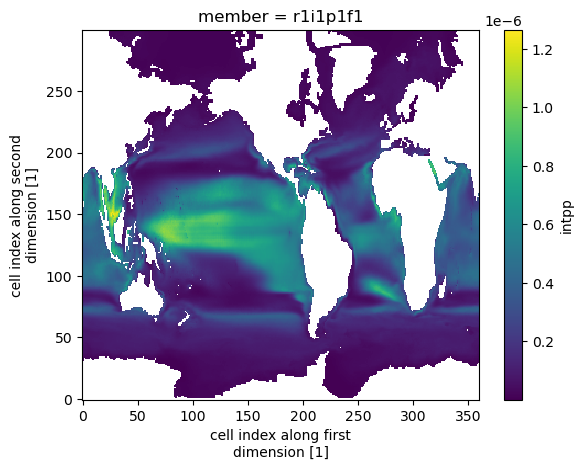

In [28]:
ds_ESM15_esorted.isel(member=0).mean('time').intpp.plot()

# 3D dataset?

In [57]:
thetao_search = cmip6_fs38_ocean_datastore.search(file_type='l',
                    variable_id='thetao',source_id='ACCESS-ESM1-5',experiment_id='historical')

In [58]:
report_esm_unique(thetao_search)

╒════════════════╤═════════════════╕
│ Category       │ Unique values   │
╞════════════════╪═════════════════╡
│ experiment_id  │ historical      │
├────────────────┼─────────────────┤
│ file_type      │ l               │
├────────────────┼─────────────────┤
│ frequency      │ mon             │
├────────────────┼─────────────────┤
│ grid_label     │ gn              │
├────────────────┼─────────────────┤
│ institution_id │ CSIRO           │
├────────────────┼─────────────────┤
│ project_id     │ CMIP            │
├────────────────┼─────────────────┤
│ realm          │ ocean           │
├────────────────┼─────────────────┤
│ source_id      │ ACCESS-ESM1-5   │
├────────────────┼─────────────────┤
│ table_id       │ Omon            │
├────────────────┼─────────────────┤
│ variable_id    │ thetao          │
╘════════════════╧═════════════════╛


In [59]:
find_chunking_info(thetao_search,'thetao',return_results=False)

╒══════════════════════════╤═════════════════════════════════════════════════════════════════════╕
│ Variable                 │ thetao                                                              │
├──────────────────────────┼─────────────────────────────────────────────────────────────────────┤
│ Chunk sizes (first file) │ 1, 25, 150, 180 ;                                                   │
├──────────────────────────┼─────────────────────────────────────────────────────────────────────┤
│ File path (first file)   │ /g/data/fs38/publications/CMIP6/CMIP/CSIRO/                         │
│                          │ ACCESS-ESM1-5/historical/r17i1p1f1/Omon/thetao/gn/                  │
│                          │ v20200803/                                                          │
│                          │ thetao_Omon_ACCESS-ESM1-5_historical_r17i1p1f1_gn_191001-191912.nc/ │
├──────────────────────────┼─────────────────────────────────────────────────────────────────────┤
│ Chunk si

In [60]:
find_chunking_info(thetao_search,'thetao',return_results=True)

╒══════════════════════════╤═════════════════════════════════════════════════════════════════════╕
│ Variable                 │ thetao                                                              │
├──────────────────────────┼─────────────────────────────────────────────────────────────────────┤
│ Chunk sizes (first file) │ 1, 25, 150, 180 ;                                                   │
├──────────────────────────┼─────────────────────────────────────────────────────────────────────┤
│ File path (first file)   │ /g/data/fs38/publications/CMIP6/CMIP/CSIRO/                         │
│                          │ ACCESS-ESM1-5/historical/r17i1p1f1/Omon/thetao/gn/                  │
│                          │ v20200803/                                                          │
│                          │ thetao_Omon_ACCESS-ESM1-5_historical_r17i1p1f1_gn_191001-191912.nc/ │
├──────────────────────────┼─────────────────────────────────────────────────────────────────────┤
│ Chunk si

{'thetao': {'chunk_sizes_first': '1, 25, 150, 180 ;',
  'file_path_first': '/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r17i1p1f1/Omon/thetao/gn/v20200803/thetao_Omon_ACCESS-ESM1-5_historical_r17i1p1f1_gn_191001-191912.nc',
  'chunk_sizes_last': '1, 25, 150, 180 ;',
  'file_path_last': '/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r3i1p1f1/Omon/thetao/gn/v20191203/thetao_Omon_ACCESS-ESM1-5_historical_r3i1p1f1_gn_189001-189912.nc'}}

In [50]:
xr.open_mfdataset('/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r3i1p1f1/Omon/thetao/gn/v20191203/thetao_Omon_ACCESS-ESM1-5_historical_r3i1p1f1_gn_189001-189912.nc')

<xarray.Dataset> Size: 3GB
Dimensions:             (time: 120, bnds: 2, lev: 50, j: 300, i: 360,
                         vertices: 4)
Coordinates:
  * time                (time) datetime64[ns] 960B 1890-01-16T12:00:00 ... 18...
  * lev                 (lev) float64 400B 5.0 15.0 25.0 ... 5.499e+03 5.831e+03
  * j                   (j) int32 1kB 0 1 2 3 4 5 6 ... 294 295 296 297 298 299
  * i                   (i) int32 1kB 0 1 2 3 4 5 6 ... 354 355 356 357 358 359
    latitude            (j, i) float64 864kB dask.array<chunksize=(300, 360), meta=np.ndarray>
    longitude           (j, i) float64 864kB dask.array<chunksize=(300, 360), meta=np.ndarray>
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds           (time, bnds) datetime64[ns] 2kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    lev_bnds            (lev, bnds) float64 800B dask.array<chunksize=(50, 2), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float64 3MB dask.array<chunksize=(300, 360, 2), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float64 3MB dask.array<chunksize=(300, 360, 2), meta=np.ndarray>
    thetao              (time, lev, j, i) float32 3GB dask.array<chunksize=(1, 25, 150, 180), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  36524.0
    creation_date:          2019-12-03T10:13:47Z
    ...                     ...
    variable_id:            thetao
    variant_label:          r3i1p1f1
    version:                v20191203
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/fab28902-5858-48f0-a6f8-307e38960df1
    license:                CMIP6 model data produced by CSIRO is licensed un...

In [61]:
%%time
ds_ESM15_esorted = load_ACCESS_ESM_ensemble(thetao_search)

Loading the dataset using the default chunking settings
CPU times: user 1min 37s, sys: 14 s, total: 1min 51s
Wall time: 2min 1s


In [62]:
ds_ESM15_esorted

<xarray.Dataset> Size: 2TB
Dimensions:    (member: 40, time: 1980, lev: 50, j: 300, i: 360, bnds: 2)
Coordinates:
  * time       (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-12-16T...
  * lev        (lev) float64 400B 5.0 15.0 25.0 ... 5.499e+03 5.831e+03
    lev_bnds   (lev, bnds) float64 800B 0.0 10.0 10.0 ... 5.665e+03 6e+03
  * j          (j) int32 1kB 0 1 2 3 4 5 6 7 ... 292 293 294 295 296 297 298 299
  * i          (i) int32 1kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
    latitude   (j, i) float64 864kB -77.88 -77.88 -77.88 ... 66.04 65.63 65.21
    longitude  (j, i) float64 864kB 80.5 81.5 82.5 83.5 ... 79.96 79.97 79.99
  * member     (member) <U9 1kB 'r1i1p1f1' 'r2i1p1f1' ... 'r40i1p1f1'
Dimensions without coordinates: bnds
Data variables:
    thetao     (member, time, lev, j, i) float32 2TB dask.array<chunksize=(1, 1, 25, 150, 180), meta=np.ndarray>
Attributes: (12/59)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            277585.0
    data_specs_version:               01.00.30
    ...                               ...
    intake_esm_attrs:member_id:       r36i1p1f1
    intake_esm_attrs:variable_id:     thetao
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:version:         v20210525
    intake_esm_attrs:_data_format_:   netcdf
    intake_esm_dataset_key:           l.CMIP.CSIRO.ACCESS-ESM1-5.historical.r...

In [67]:
%%time
ds_ESM15_esorted = load_ACCESS_ESM_ensemble(thetao_search,chunking_key='ACCESS_ESM15_3D')

Loading the dataset using the chunking settings for 'ACCESS_ESM15_3D' from the configuration file: {'chunks': {'member': 1, 'time': 12, 'lev': -1, 'i': -1, 'j': -1}}
CPU times: user 1min 31s, sys: 13.9 s, total: 1min 45s
Wall time: 1min 57s


In [68]:
ds_ESM15_esorted

<xarray.Dataset> Size: 2TB
Dimensions:    (member: 40, time: 1980, lev: 50, j: 300, i: 360, bnds: 2)
Coordinates:
  * time       (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-12-16T...
  * lev        (lev) float64 400B 5.0 15.0 25.0 ... 5.499e+03 5.831e+03
    lev_bnds   (lev, bnds) float64 800B 0.0 10.0 10.0 ... 5.665e+03 6e+03
  * j          (j) int32 1kB 0 1 2 3 4 5 6 7 ... 292 293 294 295 296 297 298 299
  * i          (i) int32 1kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
    latitude   (j, i) float64 864kB -77.88 -77.88 -77.88 ... 66.04 65.63 65.21
    longitude  (j, i) float64 864kB 80.5 81.5 82.5 83.5 ... 79.96 79.97 79.99
  * member     (member) <U9 1kB 'r1i1p1f1' 'r2i1p1f1' ... 'r40i1p1f1'
Dimensions without coordinates: bnds
Data variables:
    thetao     (member, time, lev, j, i) float32 2TB dask.array<chunksize=(1, 12, 50, 300, 360), meta=np.ndarray>
Attributes: (12/59)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            255670.0
    data_specs_version:               01.00.30
    ...                               ...
    intake_esm_attrs:member_id:       r33i1p1f1
    intake_esm_attrs:variable_id:     thetao
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:version:         v20210525
    intake_esm_attrs:_data_format_:   netcdf
    intake_esm_dataset_key:           l.CMIP.CSIRO.ACCESS-ESM1-5.historical.r...